## Crossign Accuracy in the EPL

### Imports and Fonts

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
from matplotlib import cm
from highlight_text import fig_text, ax_text
from ast import literal_eval

from PIL import Image
import urllib
import os
import requests
import json

# -- For Logos and images
from matplotlib.transforms import Bbox
class BboxLocator:
    def __init__(self, bbox, transform):
        self._bbox = bbox
        self._transform = transform
    def __call__(self, ax, renderer):
        _bbox = self._transform.transform_bbox(self._bbox)
        return ax.figure.transFigure.inverted().transform_bbox(_bbox)

In [2]:
font_path = "../assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if (y.split(".")[-1] == "ttf") or (y.split(".")[-1] == "otf"):
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("../assets/stylesheets/soc_base.mplstyle")
plt.rcParams['font.family'] = 'DM Sans'

### Read the data

Here we get detailed statistics for all players in the current season.

In [3]:
data = pd.read_csv('data/01092023_data.csv', index_col=0)

Next, we group the data to summarize our findings.

In [6]:
data_minutes = (
    data[['player_id', 'minutes_played', 'match_id']].drop_duplicates()
    .groupby(['player_id'])['minutes_played'].sum()
    .reset_index()
)

data_groupped = (
    data.groupby(['team_name', 'team_id', 'player_id', 'full_name', 'variable'])
    ['value'].sum()
    .reset_index()
)

data_groupped = (
    pd.merge(data_groupped, data_minutes, how='left', on='player_id')
)

Finally, we filter only variables of interest.

In [7]:
vars_to_keep = ['Accurate crosses', 'Crosses attempted', 'Assists', 'xA']

data_groupped = (
    data_groupped[
        (data_groupped.minutes_played > 1000) &
        (data_groupped.variable.isin(vars_to_keep))
    ].reset_index(drop=True)
)

In [8]:
data_groupped = (
    data_groupped.pivot(index=['team_name', 'team_id', 'player_id', 'full_name', 'minutes_played'], 
    columns=['variable'], values=['value'])
    .droplevel(0, axis=1).reset_index()
)

data_groupped.head()

variable,team_name,team_id,player_id,full_name,minutes_played,Accurate crosses,Assists,Crosses attempted,xA
0,AFC Bournemouth,8678,160447,Adam Smith,1548.0,10.0,1.0,25.0,0.91
1,AFC Bournemouth,8678,466672,Jefferson Lerma,1614.0,1.0,0.0,4.0,1.07
2,AFC Bournemouth,8678,532743,Philip Billing,1321.0,1.0,1.0,15.0,0.78
3,AFC Bournemouth,8678,562724,Lewis Cook,1453.0,16.0,2.0,36.0,2.02
4,AFC Bournemouth,8678,591734,Dominic Solanke,1344.0,0.0,3.0,4.0,0.86


In [9]:
top_crossers = data_groupped['Crosses attempted'].quantile(.85)
data_groupped = data_groupped[data_groupped['Crosses attempted'] > top_crossers].reset_index(drop=True)

We clean things up for the table and add player positions.

In [10]:
data_clean = data_groupped.copy()
columns_to_skip = ['team_name', 'team_id', 'player_id', 'full_name', 'minutes_played', 'cross_success']
data_clean = data_clean.assign(cross_success = lambda x: x['Accurate crosses']/x['Crosses attempted'])
for column in data_clean.columns:
    if column in columns_to_skip:
        continue
    else:
        data_clean[column] = (data_clean[column]/data_clean['minutes_played'])*90


In [11]:
data_clean

variable,team_name,team_id,player_id,full_name,minutes_played,Accurate crosses,Assists,Crosses attempted,xA,cross_success
0,AFC Bournemouth,8678,789630,Marcus Tavernier,1289.0,1.256788,0.279286,5.376261,0.070520,0.233766
1,Arsenal,9825,961995,Bukayo Saka,1446.0,1.307054,0.373444,4.543568,0.150622,0.287671
2,Arsenal,9825,1021586,Gabriel Martinelli,1454.0,0.433287,0.123796,4.704264,0.199312,0.092105
3,Aston Villa,10252,210111,Lucas Digne,1059.0,1.274788,0.000000,4.759207,0.080737,0.267857
4,Aston Villa,10252,671331,Leon Bailey,1074.0,1.340782,0.167598,5.111732,0.197765,0.262295
5,Brentford,9937,650616,Mathias Jensen,1338.0,1.748879,0.269058,5.313901,0.134529,0.329114
6,Brentford,9937,923312,Bryan Mbeumo,1362.0,0.991189,0.066079,3.832599,0.122247,0.258621
7,Brighton & Hove Albion,10204,167008,Pascal Gross,1466.0,1.227831,0.184175,6.507503,0.199523,0.188679
8,Brighton & Hove Albion,10204,416850,Solly March,1455.0,1.113402,0.185567,4.206186,0.146598,0.264706
9,Everton,8668,492586,Demarai Gray,1502.0,1.498003,0.000000,6.651132,0.152197,0.225225


In [11]:
def get_player_position(player_id):
    '''
    This function gets the main player position based on it's Fotmob ID.
    '''

    url = f'https://www.fotmob.com/api/playerData?id={player_id}'
    response = requests.get(url)
    content = json.loads(response.content)

    player_positions = content.get('origin').get('positionDesc').get('positions')
    for position in player_positions:
        if position['isMainPosition']:
            return position['strPosShort']
        else:
            continue

In [13]:
data_clean['position'] = [get_player_position(x) for x in data_clean['player_id']]
data_clean['position'].unique()

array(['CM', 'RW', 'LW', 'LB', 'CF', 'RB', 'CAM', 'CDM', 'LM'],
      dtype=object)

In [14]:
data_clean = data_clean.sort_values(by='Crosses attempted', ascending=True).reset_index(drop=True)

In [15]:
data_clean

variable,team_name,team_id,player_id,full_name,minutes_played,Accurate crosses,Assists,Crosses attempted,xA,cross_success,position
0,Brentford,9937,923312,Bryan Mbeumo,1362.0,0.991189,0.066079,3.832599,0.122247,0.258621,CF
1,West Ham United,8654,523825,Jarrod Bowen,1612.0,0.781638,0.000000,4.131514,0.106079,0.189189,RW
2,Manchester United,10260,157723,Christian Eriksen,1253.0,0.933759,0.430966,4.166002,0.162330,0.224138,CDM
3,Brighton & Hove Albion,10204,416850,Solly March,1455.0,1.113402,0.185567,4.206186,0.146598,0.264706,RB
4,Nottingham Forest,10203,789502,Morgan Gibbs-White,1379.0,1.044235,0.130529,4.307469,0.154677,0.242424,CAM
5,Leicester City,8197,493165,James Maddison,1100.0,0.900000,0.327273,4.500000,0.220091,0.200000,RW
6,Arsenal,9825,961995,Bukayo Saka,1446.0,1.307054,0.373444,4.543568,0.150622,0.287671,RW
7,Arsenal,9825,1021586,Gabriel Martinelli,1454.0,0.433287,0.123796,4.704264,0.199312,0.092105,LW
8,Aston Villa,10252,210111,Lucas Digne,1059.0,1.274788,0.000000,4.759207,0.080737,0.267857,LB
9,Aston Villa,10252,671331,Leon Bailey,1074.0,1.340782,0.167598,5.111732,0.197765,0.262295,RW


## The Table

In [36]:
def draw_player_image_at_ax(player_id, ax, grayscale=False):
    '''
    '''
    fotmob_url = 'https://images.fotmob.com/image_resources/playerimages/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{player_id:.0f}.png'))
    if grayscale:
        club_icon = club_icon.convert('LA')
    ax.imshow(club_icon)
    ax.axis('off')
    return ax

def draw_club_image_at_ax(team_id, ax, grayscale=False):
    '''
    '''
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_id:.0f}.png'))
    if grayscale:
        club_icon = club_icon.convert('LA')
    ax.imshow(club_icon)
    ax.axis('off')
    return ax

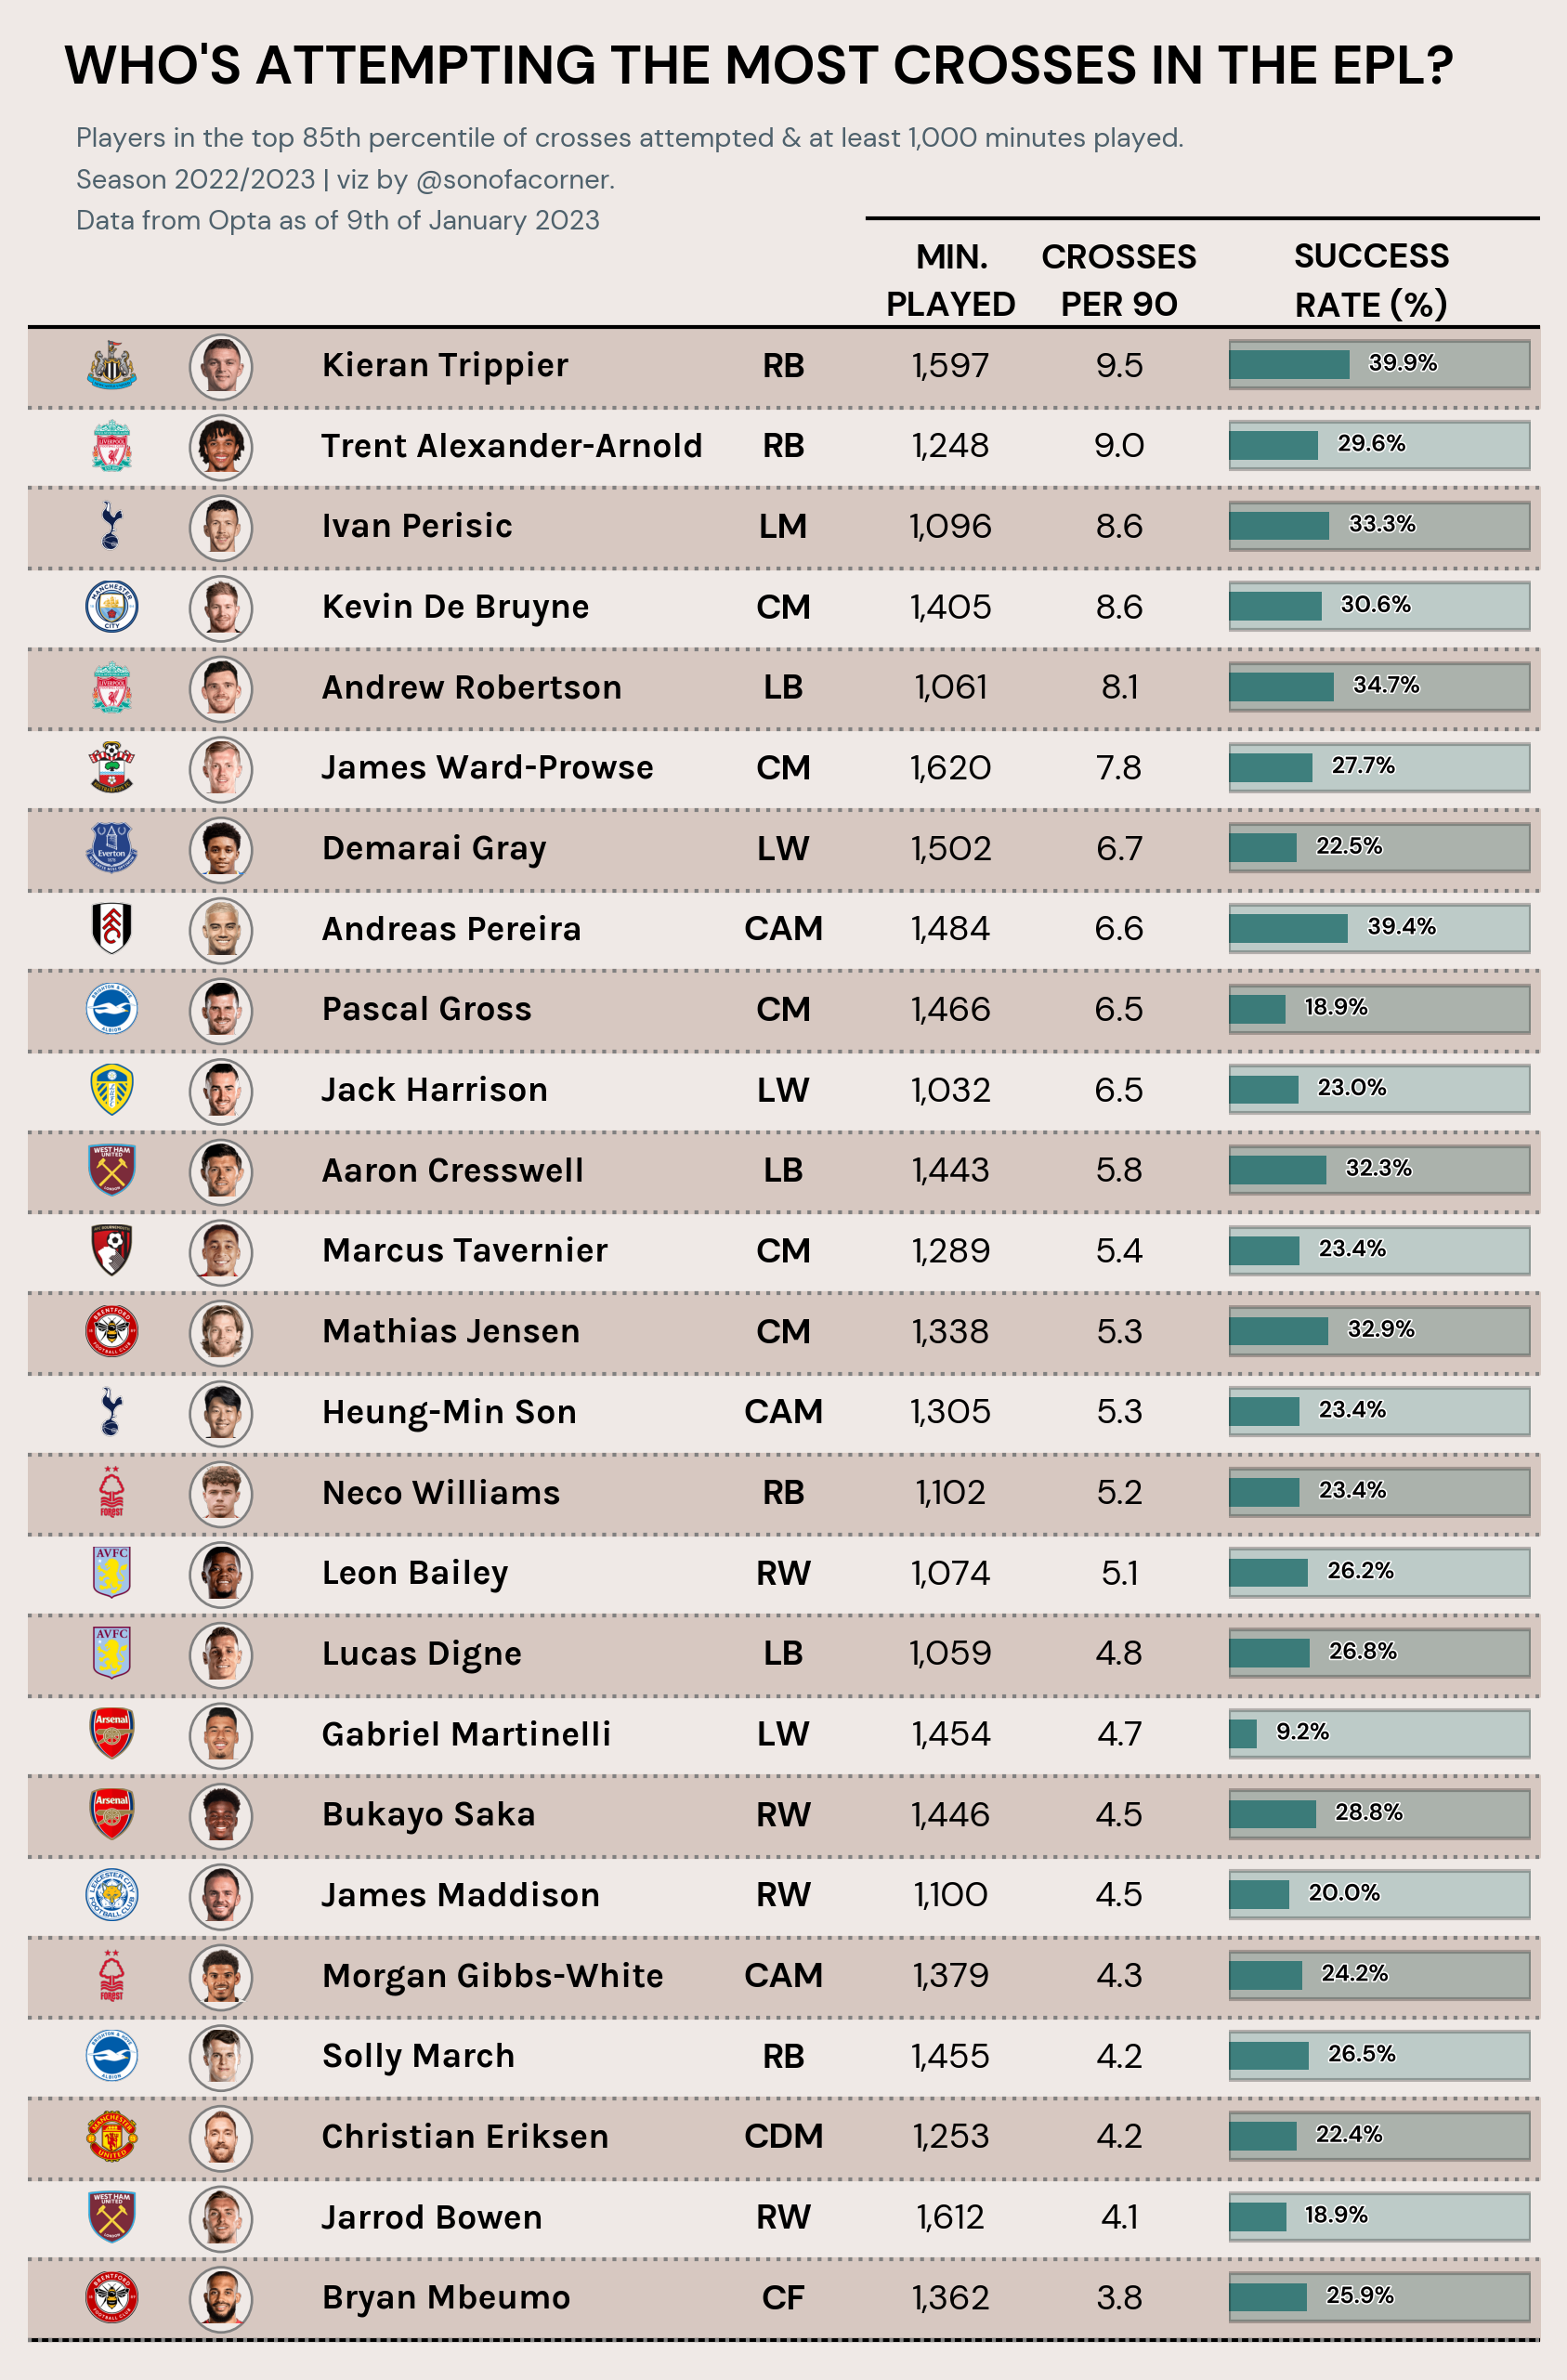

In [17]:
fig = plt.figure(figsize=(7,10), dpi=300)
ax = plt.subplot()

nrows = data_clean.shape[0]
ncols = data_clean.shape[1] - 3 # because I want to remove aprox. 3 columns from my DF

ax.set_xlim(0, ncols + 1)
ax.set_ylim(-.65, nrows + 1)

# calculate asymmetry of x and y axes: (I have no idea how this works)
x0, y0 = ax.transAxes.transform((0, 0)) # lower left in pixels
x1, y1 = ax.transAxes.transform((1, 1)) # upper right in pixes
dx = x1 - x0
dy = y1 - y0
maxd = max(dx, dy)
width = .26 * maxd / dx
height = .81 * maxd / dy

# Iterate
for y in range(0, nrows):
    # -- Club Logo
    bbox = Bbox.from_bounds(0, y - .295, 1, .65)
    logo_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    draw_club_image_at_ax(data_clean['team_id'].iloc[y], logo_ax)
    # -- Player picture
    circle = Ellipse((1.15, y), width, height, ec='grey', fc=fig.get_facecolor(), transform=ax.transData, lw=.65)
    bbox = Bbox.from_bounds(.65, y - .295, 1, .65)
    logo_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    draw_player_image_at_ax(data_clean['player_id'].iloc[y], logo_ax)
    ax.add_artist(circle)
    # -- Player name
    ax_text(
        x=1.75, y=y,
        s=data_clean['full_name'].iloc[y],
        weight='bold', size=9,
        ha='left', va='center', ax=ax, family='Karla'
    )
    # -- Player position
    ax_text(
        x=4.5, y=y,
        s=data_clean['position'].iloc[y],
        weight='bold', size=9,
        ha='center', va='center', ax=ax
    )
    # -- Minutes played
    ax_text(
        x=5.5, y=y,
        s=f"{data_clean['minutes_played'].iloc[y]:,.0f}",
        size=9,
        ha='center', va='center', ax=ax
    )
    # # -- Crosses
    ax_text(
        x=6.5, y=y,
        s=f"{data_clean['Crosses attempted'].iloc[y]:,.1f}",
        size=9,
        ha='center', va='center', ax=ax
    )
    # # -- Battery Chart
    bbox = Bbox.from_bounds(7.15, y - .295, 1.8, .65)
    battery_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    battery_ax.set_xlim(0,1)
    battery_ax.barh(y=.5, width=data_clean['cross_success'].iloc[y], height=.3, alpha=.85)
    battery_ax.barh(y=.5, width=1, height=.5, alpha=.25, color='#287271', ec='black')
    text_ = battery_ax.annotate(
        xy=(data_clean['cross_success'].iloc[y], .5),
        xytext=(5,0),
        textcoords='offset points',
        text=f"{data_clean['cross_success'].iloc[y]:.1%}",
        ha='left', va='center',
        size=6, weight='bold'
    )
    text_.set_path_effects(
                [path_effects.Stroke(linewidth=.75, foreground="white"), 
                path_effects.Normal()]
            )
    battery_ax.set_axis_off()
    

# -- Draw border lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows - .5, nrows - .5], lw=1, color='black', zorder=3)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [-.5, -.5], lw=1, color='black', zorder=3)
for x in range(nrows):
    if x % 2 == 0:
        ax.fill_between(x=[ax.get_xlim()[0], ax.get_xlim()[1]], y1=x-.5, y2=x+.5, color='#d7c8c1', zorder=-1)
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x - .5, x - .5], lw=1, color='grey', ls=':', zorder=3)

ax.set_axis_off()


# -- Column titles
ax_text(
    x=5.5, y=nrows + .05,
    s='MIN.\nPLAYED',
    size=9,
    ha='center', va='center', ax=ax,
    textalign='center', weight='bold'
)
ax_text(
    x=6.5, y=nrows + .05,
    s='CROSSES\nPER 90',
    size=9,
    ha='center', va='center', ax=ax,
    textalign='center', weight='bold'
)
ax_text(
    x=8, y=nrows + .05,
    s='SUCCESS\nRATE (%)',
    size=9,
    ha='center', va='center', ax=ax,
    textalign='center', weight='bold'
)

ax.plot([5, ax.get_xlim()[1]], [nrows + .85, nrows + .85], lw=1, color='black', zorder=3)

fig_text(
    x = 0.5, y = .92, 
    s = "WHO'S ATTEMPTING THE MOST CROSSES IN THE EPL?",
    va = "bottom", ha = "center",
    fontsize = 14, color = "black", font = "DM Sans", weight = "bold"
)
fig_text(
	x = 0.15, y = .87, 
    s = "Players in the top 85th percentile of crosses attempted & at least 1,000 minutes played.\nSeason 2022/2023 | viz by @sonofacorner.\nData from Opta as of 9th of January 2023",
	va = "bottom", ha = "left",
	fontsize = 7, color = "#4E616C", font = "DM Sans"
)

plt.savefig(
	"figures/01092023_epl_crosses.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.savefig(
	"figures/01092023_epl_crosses_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)

## Who gets the most dribbled past?

In [25]:
data_minutes = (
    data[['player_id', 'minutes_played', 'match_id']].drop_duplicates()
    .groupby(['player_id'])['minutes_played'].sum()
    .reset_index()
)

data_groupped = (
    data.groupby(['team_name', 'team_id', 'player_id', 'full_name', 'variable'])
    ['value'].sum()
    .reset_index()
)

data_groupped = (
    pd.merge(data_groupped, data_minutes, how='left', on='player_id')
)

In [26]:
vars_to_keep = ['Dribbles attempted', 'Successful dribbles']

data_groupped = (
    data_groupped[
        (data_groupped.minutes_played > 400) &
        (data_groupped.variable.isin(vars_to_keep))
    ].reset_index(drop=True)
)

In [27]:
data_groupped = (
    data_groupped.pivot(index=['team_name', 'team_id', 'player_id', 'full_name', 'minutes_played'], 
    columns=['variable'], values=['value'])
    .droplevel(0, axis=1).reset_index()
)

data_groupped.head()

variable,team_name,team_id,player_id,full_name,minutes_played,Dribbles attempted,Successful dribbles
0,AFC Bournemouth,8678,160447,Adam Smith,1548.0,14.0,3.0
1,AFC Bournemouth,8678,176186,Neto,675.0,0.0,0.0
2,AFC Bournemouth,8678,194323,Ryan Fredericks,453.0,5.0,1.0
3,AFC Bournemouth,8678,439369,Ryan Christie,831.0,29.0,15.0
4,AFC Bournemouth,8678,466672,Jefferson Lerma,1614.0,10.0,6.0


In [28]:
data_groupped[data_groupped['full_name'] == 'Kaoru Mitoma']

variable,team_name,team_id,player_id,full_name,minutes_played,Dribbles attempted,Successful dribbles
76,Brighton & Hove Albion,10204,862608,Kaoru Mitoma,568.0,25.0,14.0


In [22]:
data[(data['full_name'] == 'Kaoru Mitoma') & (data['variable'] == 'Dribbles attempted')]

,team_id,team_name,player_id,first_name,last_name,full_name,role,position,time_subbed_on,time_subbed_off,is_captain,fotmob_rating,minutes_played,variable,value,match_id
686,10204,Brighton & Hove Albion,862608,Kaoru,Mitoma,Kaoru Mitoma,Midfielder,NaN,75.0,NaN,False,6.75,16.0,Dribbles attempted,2.0,3900945
725,10204,Brighton & Hove Albion,862608,Kaoru,Mitoma,Kaoru Mitoma,Midfielder,NaN,90.0,NaN,False,0.00,1.0,Dribbles attempted,0.0,3900961
752,10204,Brighton & Hove Albion,862608,Kaoru,Mitoma,Kaoru Mitoma,Midfielder,NaN,79.0,NaN,False,6.42,11.0,Dribbles attempted,0.0,3900965
694,10204,Brighton & Hove Albion,862608,Kaoru,Mitoma,Kaoru Mitoma,Midfielder,NaN,63.0,NaN,False,6.31,27.0,Dribbles attempted,1.0,3900974
738,10204,Brighton & Hove Albion,862608,Kaoru,Mitoma,Kaoru Mitoma,Midfielder,NaN,65.0,NaN,False,6.63,25.0,Dribbles attempted,4.0,3901018
707,10204,Brighton & Hove Albion,862608,Kaoru,Mitoma,Kaoru Mitoma,Midfielder,NaN,67.0,NaN,False,6.79,23.0,Dribbles attempted,2.0,3901024
762,10204,Brighton & Hove Albion,862608,Kaoru,Mitoma,Kaoru Mitoma,Midfielder,NaN,46.0,NaN,False,6.89,45.0,Dribbles attempted,1.0,3901033
724,10204,Brighton & Hove Albion,862608,Kaoru,Mitoma,Kaoru Mitoma,Midfielder,LW,NaN,73.0,False,8.15,73.0,Dribbles attempted,1.0,3901065
725,10204,Brighton & Hove Albion,862608,Kaoru,Mitoma,Kaoru Mitoma,Midfielder,LW,NaN,90.0,False,8.53,89.0,Dribbles attempted,3.0,3901081
749,10204,Brighton & Hove Albion,862608,Kaoru,Mitoma,Kaoru Mitoma,Midfielder,LW,NaN,NaN,False,7.20,90.0,Dribbles attempted,7.0,3901101


In [23]:
# data_groupped['total_duels'] = data_groupped['Total aerial duels'] + data_groupped['Total ground duels']
# data_groupped['total_duels_won'] = data_groupped['Aerial duels won'] + data_groupped['Ground duels won']
worst_defenders = data_groupped['Dribbles attempted'].quantile(.85)
data_groupped = data_groupped[data_groupped['Dribbles attempted'] > worst_defenders].reset_index(drop=True)

In [29]:
data_clean = data_groupped.copy()
columns_to_skip = ['team_name', 'team_id', 'player_id', 'full_name', 'minutes_played', 'duel_success']
data_clean = data_clean.assign(duel_success = lambda x: x['Successful dribbles']/x['Dribbles attempted'])
for column in data_clean.columns:
    if column in columns_to_skip:
        continue
    else:
        data_clean[column] = (data_clean[column]/data_clean['minutes_played'])*90


In [30]:
data_clean = data_clean[~data_clean['duel_success'].isna()].sort_values(by='Dribbles attempted', ascending=True).reset_index(drop=True)

In [31]:
worst_defenders = data_clean['Dribbles attempted'].quantile(.85)
data_clean = data_clean[data_clean['Dribbles attempted'] > worst_defenders].reset_index(drop=True)

In [32]:
data_clean['position'] = [get_player_position(x) for x in data_clean['player_id']]
data_clean['position'].unique()

array(['CM', 'RB', 'CF', 'RW', 'LW', 'ST', 'CAM', 'LM', 'LB'],
      dtype=object)

In [34]:
data_clean = data_clean.tail(30).reset_index(drop=True)

In [97]:
data_clean.at[0, 'position'] = 'LM'

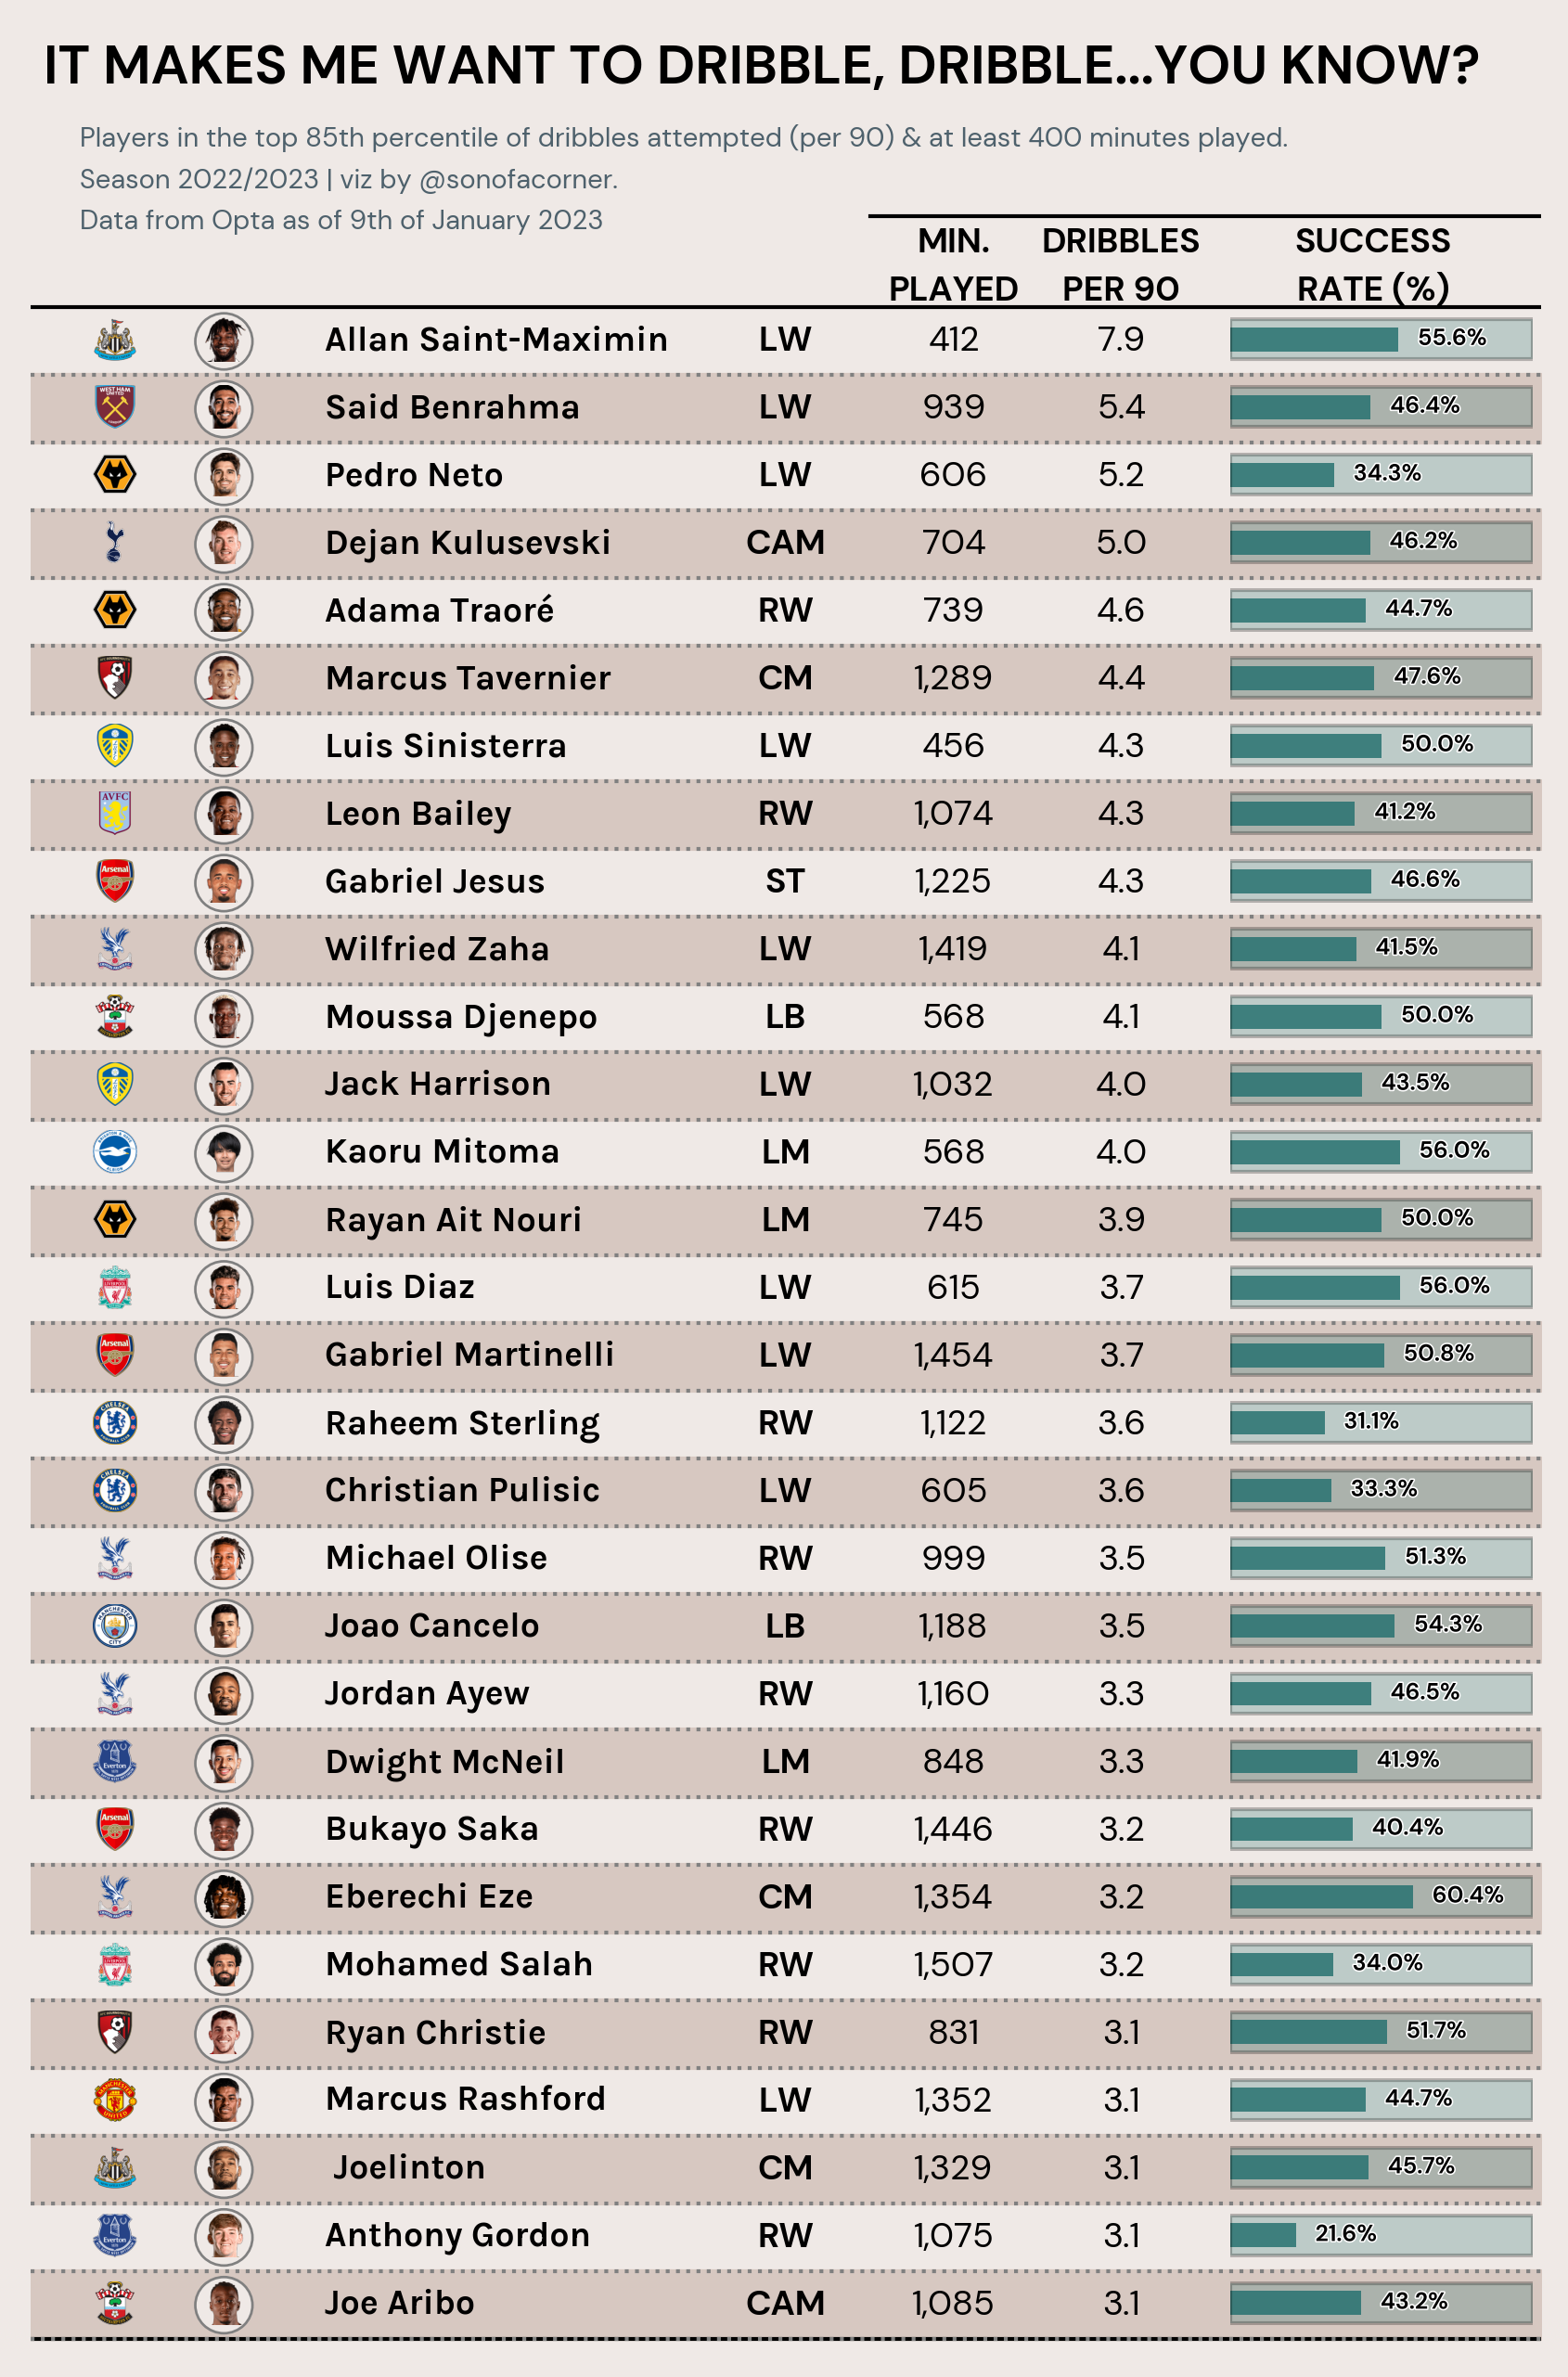

In [38]:
fig = plt.figure(figsize=(7,10), dpi=300)
ax = plt.subplot()

nrows = data_clean.shape[0]
ncols = data_clean.shape[1] - 1 # because I want to remove aprox. 3 columns from my DF

ax.set_xlim(0, ncols + 1)
ax.set_ylim(-.65, nrows + 1)

# calculate asymmetry of x and y axes: (I have no idea how this works)
x0, y0 = ax.transAxes.transform((0, 0)) # lower left in pixels
x1, y1 = ax.transAxes.transform((1, 1)) # upper right in pixes
dx = x1 - x0
dy = y1 - y0
maxd = max(dx, dy)
width = .24 * maxd / dx
height = .83 * maxd / dy

# Iterate
for y in range(0, nrows):
    # -- Club Logo
    bbox = Bbox.from_bounds(0, y - .295, 1, .65)
    logo_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    draw_club_image_at_ax(data_clean['team_id'].iloc[y], logo_ax)
    # -- Player picture
    circle = Ellipse((1.15, y), width, height, ec='grey', fc=fig.get_facecolor(), transform=ax.transData, lw=.65)
    bbox = Bbox.from_bounds(.65, y - .295, 1, .65)
    logo_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    draw_player_image_at_ax(data_clean['player_id'].iloc[y], logo_ax)
    ax.add_artist(circle)
    # -- Player name
    ax_text(
        x=1.75, y=y,
        s=data_clean['full_name'].iloc[y],
        weight='bold', size=9,
        ha='left', va='center', ax=ax, family='Karla'
    )
    # -- Player position
    ax_text(
        x=4.5, y=y,
        s=data_clean['position'].iloc[y],
        weight='bold', size=9,
        ha='center', va='center', ax=ax
    )
    # -- Minutes played
    ax_text(
        x=5.5, y=y,
        s=f"{data_clean['minutes_played'].iloc[y]:,.0f}",
        size=9,
        ha='center', va='center', ax=ax
    )
    # # -- Crosses
    ax_text(
        x=6.5, y=y,
        s=f"{data_clean['Dribbles attempted'].iloc[y]:,.1f}",
        size=9,
        ha='center', va='center', ax=ax
    )
    # # -- Battery Chart
    bbox = Bbox.from_bounds(7.15, y - .295, 1.8, .65)
    battery_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    battery_ax.set_xlim(0,1)
    battery_ax.barh(y=.5, width=data_clean['duel_success'].iloc[y], height=.3, alpha=.85)
    battery_ax.barh(y=.5, width=1, height=.5, alpha=.25, color='#287271', ec='black')
    text_ = battery_ax.annotate(
        xy=(data_clean['duel_success'].iloc[y], .5),
        xytext=(5,0),
        textcoords='offset points',
        text=f"{data_clean['duel_success'].iloc[y]:.1%}",
        ha='left', va='center',
        size=6, weight='bold'
    )
    text_.set_path_effects(
                [path_effects.Stroke(linewidth=.75, foreground="white"), 
                path_effects.Normal()]
            )
    battery_ax.set_axis_off()
    

# -- Draw border lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows - .5, nrows - .5], lw=1, color='black', zorder=3)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [-.5, -.5], lw=1, color='black', zorder=3)
for x in range(nrows):
    if x % 2 == 0:
        ax.fill_between(x=[ax.get_xlim()[0], ax.get_xlim()[1]], y1=x-.5, y2=x+.5, color='#d7c8c1', zorder=-1)
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x - .5, x - .5], lw=1, color='grey', ls=':', zorder=3)

ax.set_axis_off()


# -- Column titles
ax_text(
    x=5.5, y=nrows + .1,
    s='MIN.\nPLAYED',
    size=9,
    ha='center', va='center', ax=ax,
    textalign='center', weight='bold'
)
ax_text(
    x=6.5, y=nrows + .1,
    s='DRIBBLES\nPER 90',
    size=9,
    ha='center', va='center', ax=ax,
    textalign='center', weight='bold'
)
ax_text(
    x=8, y=nrows + .1,
    s='SUCCESS\nRATE (%)',
    size=9,
    ha='center', va='center', ax=ax,
    textalign='center', weight='bold'
)

ax.plot([5, ax.get_xlim()[1]], [nrows + .85, nrows + .85], lw=1, color='black', zorder=3)

fig_text(
    x = 0.5, y = .92, 
    s = "IT MAKES ME WANT TO DRIBBLE, DRIBBLE...YOU KNOW?",
    va = "bottom", ha = "center",
    fontsize = 14, color = "black", font = "DM Sans", weight = "bold"
)
fig_text(
	x = 0.15, y = .87, 
    s = "Players in the top 85th percentile of dribbles attempted (per 90) & at least 400 minutes played.\nSeason 2022/2023 | viz by @sonofacorner.\nData from Opta as of 9th of January 2023",
	va = "bottom", ha = "left",
	fontsize = 7, color = "#4E616C", font = "DM Sans"
)

plt.savefig(
	"figures/01092023_epl_dribbles2.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

# plt.savefig(
# 	"figures/01092023_epl_crosses_tr.png",
# 	dpi = 600,
# 	facecolor = "none",
# 	bbox_inches="tight",
#     edgecolor="none",
# 	transparent = True
# )